[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/051_gans/gans.ipynb)

## DCGAN



DCGAN de dataset STL10 que contiene 5000 datos de entrenamiento para 10 clases de objetos, inicialmente se reducira la imagen original de 96 x 96 a la mitad

In [177]:
import torch
import torchvision
import torchvision.transforms as transforms
import albumentations as A

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [178]:

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convierte a escala de grises
    transforms.Resize((48, 48)),# Convierte las imágenes a tensores de PyTorch
    transforms.ToTensor(),

])

trainset = torchvision.datasets.STL10(root='./data', split='train',download=True, transform = transform)


Files already downloaded and verified


In [179]:
stl10_classes = trainset.classes
classes = stl10_classes
print(classes)
num_values = len(set(classes))
print(num_values)

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
10


In [180]:
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, trainset):
        self.imgs = torch.tensor([np.array(i[0]).flatten() / 1 for i in trainset], dtype=torch.float, device=device)
        self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)


    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, ix):
        return self.imgs[ix], self.labels[ix]

train = Dataset(trainset)
len(train)


5000

In [181]:
img, label = train[0]
print(img.shape, img.dtype, img.max(), img.min())

torch.Size([2304]) torch.float32 tensor(0.8745, device='cuda:0') tensor(0.1294, device='cuda:0')


In [182]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 2304]), torch.Size([32]))

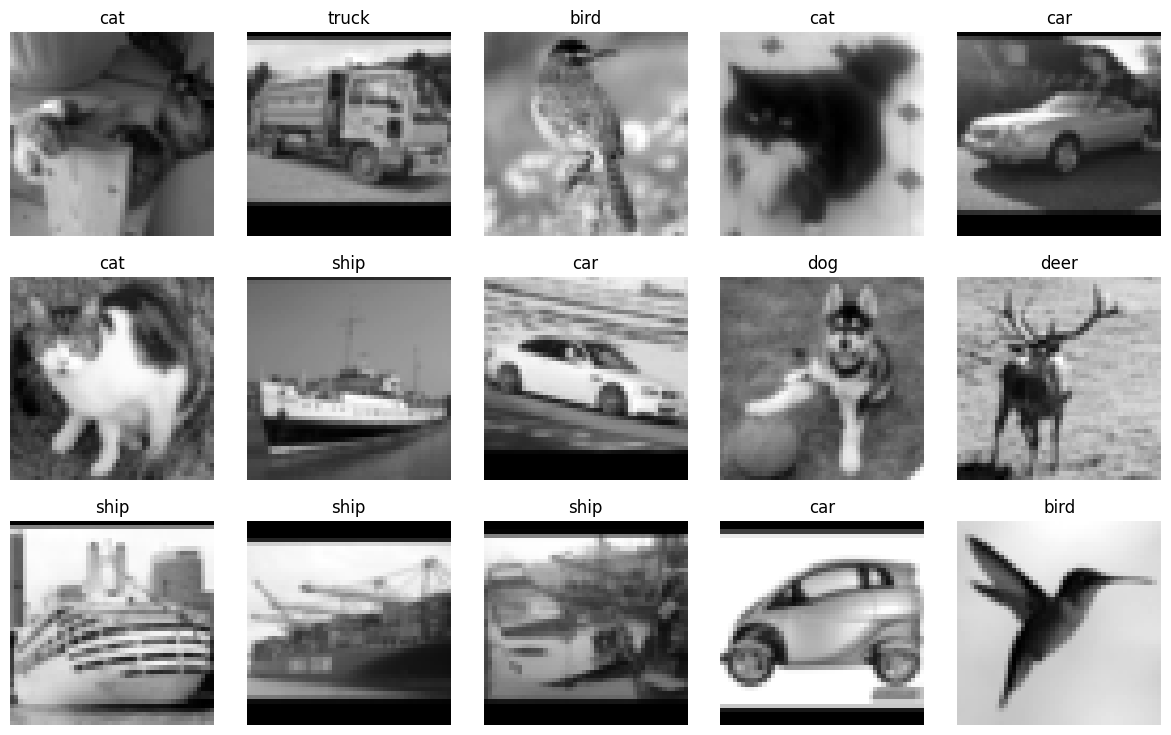

In [183]:
import random
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))

for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(train)-1)
        img, label = train[ix]

        # Verificamos si 'label' es un tensor y obtenemos el valor como un entero
        label_value = label.item() if isinstance(label, torch.Tensor) else label

        plt.imshow(img.reshape(48, 48).cpu(), cmap="gray")  # añadir cmap="gray" para imágenes en escala de grises
        plt.axis('off')
        plt.title(classes[label_value])

plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()


Obviamente, nuestro generador inicializado genera imágenes aleatorias que en nada se parecen a las reales.

In [184]:
from fastprogress import master_bar, progress_bar
import numpy as np
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

def add_noise(img, noise_factor=0.01):
    return img + noise_factor * torch.randn_like(img)

def fit(g, d, dataloader, epochs=30, crit=None):#crit es una funcion de perdida
  g.to(device)
  d.to(device)

  g_optimizer = torch.optim.Adam(g.parameters(), lr=4e-4)
  d_optimizer = torch.optim.Adam(d.parameters(), lr=2e-4)

  crit = nn.BCEWithLogitsLoss() if crit == None else crit
  g_loss, d_loss = [], []
  mb = master_bar(range(1, epochs+1))
  hist = {'g_loss': [], 'd_loss': []}
  for epoch in mb:

    for X, y in progress_bar(dataloader, parent=mb):
      X, y = X.to(device), y.to(device)
      g.eval() #modo evaluacion al generador porque se entrenara 1ero al discriminador
      d.train()#discriminador en modo entrenamiento
      noise = torch.randn((X.size(0), g.input_size)).to(device) #tamaño del batch x input del generador
      genenerated_images = g(noise)# al generador se pasa este tensor de ruido para obtener imagenes generadas
      genenerated_images = genenerated_images.to(device)

      d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])#entrada del disrcim
      d_input = add_noise(d_input)

      d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)# esta creando las salidas al ponerle 1, para diferenciar las generadas(con etiqueta 1) con las de ruido (etiq0)
      d_optimizer.zero_grad()
      d_output = d(d_input) # se pasan las imagenes combinandas al discriminador para obtener las prediciones(aqui ocurre todo)
      d_l = crit(d_output, d_gt) # Se calcula la pérdida del discriminador comparando sus predicciones (d_output)

      d_l.backward()
      d_optimizer.step()
      d_loss.append(d_l.item())
      # entrenamos el generador
      g.train()
      d.eval() # discriminador no actualizara sus pesos y solo queremos al discriminador para evaluar las imagenes generadas
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      genenerated_images = genenerated_images.to(device)
      d_output = d(genenerated_images)
      g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
      #   optimización
      g_optimizer.zero_grad()
      g_l = crit(d_output, g_gt)
      g_l.backward()
      g_optimizer.step()
      g_loss.append(g_l.item())
      # logs
      mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
    mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
    hist['g_loss'].append(np.mean(g_loss))
    hist['d_loss'].append(np.mean(d_loss))
  return hist

## DCGANs

Podemos usar *DCGANs* (*deep convolutional GANs*) para obtener mejores generadores utilizando redes convolucionales. En este caso, necesitaremos arquitecturas diferentes para generador y discriminador.

![](https://gluon.mxnet.io/_images/dcgan.png)

El generador recibirá un vector de 100 valores aleatorios y después aplicaremos varias capas de convoluciones transpuestas (que aumentarán el tamaño de los mapas de caracterísitcas, como hicimos en nuestras redes para [segmentación](https://sensioai.com/blog/50_cv_segmentacion)) hasta obtener la imagen generada.

que diablos es segmentacion semantica

In [185]:
# class Generator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.input_size = 100
#         self.inp = nn.Sequential(
#             nn.Linear(self.input_size, 12*12*128),
#             nn.BatchNorm1d(128*12*12),
#             #nn.LeakyReLU(0.2, inplace=True)
#         )
#         self.main = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),

#             nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.Tanh()
#         )

#     def forward(self, x):
#         x = self.inp(x)
#         x = x.view(-1, 128, 12, 12)
#         x = self.main(x)
#         x = x.view(x.size(0), 48*48)
#         return x

import torch.nn.init as init

# def weights_init(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
#         init.kaiming_normal_(m.weight.data)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 100
        self.inp = nn.Sequential(
            nn.Linear(self.input_size, 6*6*256),  # Cambio a 256 canales
            nn.BatchNorm1d(256*6*6),
        )
        self.main = nn.Sequential(
            # De 12x12 a 24x24
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # 256 a 128 canales
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # De 24x24 a 48x48
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),  # 128 a 64 canales
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),  # 64 a 1 canal (escala de grises)
            nn.Tanh()
        )
        #self.apply(weights_init)

    def forward(self, x):
        x = self.inp(x)
        x = x.view(-1, 256, 6, 6)  # Cambio a 256 canales
        x = self.main(x)
        x = x.view(x.size(0), 48*48)
        return x





In [186]:
generator = Generator()
output = generator(torch.randn(64, 100))
output.shape

torch.Size([64, 2304])

Al final del generador usamos una activación `tanh`, que dará valores entre -1 y 1. Por este motivo tenemos que re-normalizar nuestras imágenes en el dataset.

In [187]:

class Dataset(torch.utils.data.Dataset):
    def __init__(self, trainset):
        # Simplemente extraer imágenes y etiquetas del trainset ya transformado
        self.imgs = [item[0].view(-1) for item in trainset]  # Aquí aplanamos las imágenes
        self.labels = [item[1] for item in trainset]

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, ix):
        return self.imgs[ix], self.labels[ix]

In [188]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([2304]),
 torch.float32,
 tensor(0.8745, device='cuda:0'),
 tensor(0.1294, device='cuda:0'))

In [189]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 2304]), torch.Size([32]))

En cuanto al discriminador, utilizaremos una `CNN` típica como las que conocemos cuando hacemos clasificación de imagen.

In [190]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.main = nn.Sequential(
#             nn.Conv2d(1, 64, 4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),

#             nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.ReLU(True),

#             # nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
#             # nn.BatchNorm2d(128),
#             # nn.LeakyReLU(0.2, inplace=True),

#             # nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
#             # nn.BatchNorm2d(256),
#             # nn.LeakyReLU(0.2, inplace=True)
#         )
#         self.out = nn.Sequential(
#             nn.Linear(128*12*12, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = x.view(x.size(0), 1, 48, 48)
#         x = self.main(x)
#         x = x.view(x.size(0), -1)
#         x = self.out(x)
#         return x
import torch.nn.init as init

# def weights_init(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
#         init.kaiming_normal_(m.weight.data)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # De 48x48 a 24x24
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # De 24x24 a 12x12
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # De 12x12 a 6x6
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),  # Añadido para llegar a 256 canales
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )
        self.out = nn.Sequential(
            nn.Linear(256*6*6, 1),  # Ajustado para reflejar el cambio a 6x6 con 256 canales
            nn.Sigmoid()
        )
        #self.apply(weights_init)

    def forward(self, x):
        x = x.view(x.size(0), 1, 48, 48)
        x = self.main(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x




In [191]:
discriminator = Discriminator()
output = discriminator(torch.randn(64, 48*48))
output.shape

torch.Size([64, 1])

Ahora podemos utilizar exactamente el mismo bucle de entrenamiento anterior para obtener un nuevo generador.

In [192]:
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss())

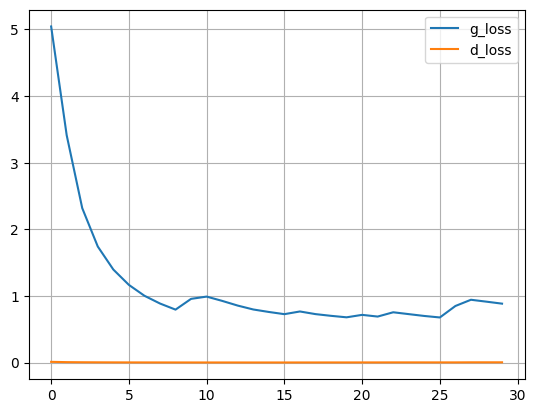

In [195]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

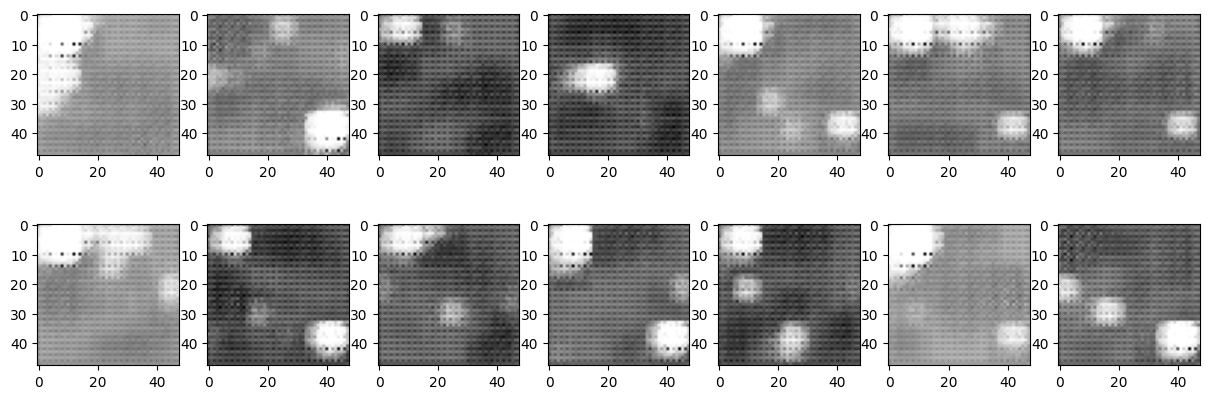

In [196]:
generator.eval()
with torch.no_grad():
    noise = torch.randn((14, generator.input_size)).to(device)
    generated_images = generator(noise)
    fig, axs = plt.subplots(2, 7, figsize=(15, 5))
    i = 0
    for ax in axs:
        for _ax in ax:
            img = generated_images[i].view(48, 48).cpu()
            _ax.imshow(img, cmap="gray")
            i += 1
    plt.show()

> ⚡¿Te ves capaz de utilizar este código como base para entrenar una *GAN* capaz de generar caras realistas? Para ello puedes utilizar el dataset [CelebA](https://pytorch.org/docs/stable/torchvision/datasets.html#celeba)

## Resumen

En este post hemos aprendido a implementar *GANs*, redes neuronales capaces de generar datos similares a los usados en el entrenamiento, en este caso imágenes. Este tipo de arquitecturas están formadas por dos redes neuronales que compiten entre sí durante el entrenamiento: el generador y el discriminador. El generador se encarga de generar imágenes falsas a partir de un vector de valores aleatorios, que se puede interpretar como una versión comprimida de la imagen, mientras que el discriminador se encarga de distinguir entre imágenes reales, obtenidas del dataset, y falsas, generadas por el generador. Una vez entrenado el modelo, descartamos el discriminador y nos quedamos con el generador que será capaz de generar imágenes realistas, similares a la usadas en el dataset. Este tipo de modelos se utilizan para generar caras de gente que no existe, colorear imágenes en blanco y negro, generar imágenes realistas a partir de máscaras de segmentación, incluso los famosos *deep fakes*.